In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun, R_jup
import astropy.units as u

import os
import copy



from funcs.model import full_model, aflare, calculate_specific_flare_flux, aflare, calculate_angular_radius

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

#-----------------------------------
import numpy as np
import pandas as pd

from altaipony.altai import find_iterative_median
from altaipony.flarelc import FlareLightCurve
from funcs.multiperiod import remove_sinusoidal
from funcs.helper import fetch_lightcurve

import time

# Different flare/active region configurations have different numbers of parameters
log_probs = {"log_probability": 6, # one flare, one active region
             "log_probability_2flares": 9, # two flares, one active region
             "log_probability_2flares2ars": 10 # two flares, two active regions
            }



# Create a time stamp for this run
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())


In [57]:
tstamp

'02_08_2020_17_58'

In [58]:
# Read in target parameters
# ALL TARGETS MUST BE DEFINED IN THIS TABLE AND HAVE LIGHT CURVE
# OTHERWISE NOTHING WILL WORK
lcs = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")

# Choose target from table
target_N = 4
target = lcs.iloc[target_N]

# Pick up inclination and uncertainty
i_mu, i_sigma = target.i_mu, target.i_sigma

# Pick up quiescent luminosity
qlum = target.tlum * u.erg/u.s

# Pick up stellar radius
R = target.rad * R_sun

target

ID                    230120143
QCS                          16
typ                         slc
cadence_min                   2
mission                    tess
prefix                      TIC
origin                  generic
h_mission                  TESS
SpT                          M7
view_start                 1741
view_stop                  1743
view_min                   2320
view_max                   2500
BJDoff                  2457000
tstart                  1741.62
ampl_min                    1.5
ampl_max                    2.5
GRP                         NaN
plxmas                      NaN
eplxmas                     NaN
RA                      250.086
Dec                     67.6013
J                         9.854
R                           NaN
Gaia_G                   13.557
vsini_kms                  10.8
e_vsini_kms                 0.7
Prot_d                 0.378325
sini                  0.6844128
Ref                Kesseli+2018
identifier                  NaN
Rstar   

In [61]:

# Get the light curve of the target
# from a pre-defined path
flck = fetch_lightcurve(target)

# We are dealing with ultrafast rotators witha simple sinusoidal signal
t, sflux, model, period = remove_sinusoidal(target, plot=False, save=False)

# define flare light curve so that you can use find_iterative_median later
flcd = FlareLightCurve(time=t, 
                       detrended_flux=sflux, 
                       detrended_flux_err=np.array(len(t)*[np.nanmean(flck.flux_err)]))


# Choose the light curve range to use for the model fit
choice = (t > target.view_start +.3) & (t < target.view_stop-.25) 
t = t[choice]
flux = sflux[choice]

# Define the flux error
flux_err = np.nanmean(flcd.detrended_flux_err)

# Find the median flux in the chosen light curve range
# by clipping outliers iteratively
flcd = flcd[choice]
median = np.nanmean(find_iterative_median(flcd).it_med)


# Convert time array to rotation phase array
# using the rotation period of the star
phi = (t - t[0]) / target.Prot_d * 2 * np.pi

5% (953/17765) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (953/17765) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (953/17765) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (953/17765) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (953/17765) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (953/17765) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


{'time': array([1738.65173791, 1738.6531268 , 1738.65451569, ..., 1763.31571967,
       1763.31710857, 1763.31849747]), 'flux': array([2365.29  , 2358.666 , 2372.7466, ..., 2381.0286, 2339.525 ,
       2369.3196], dtype=float32), 'flux_err': array([10.914513, 10.922161, 10.897813, ..., 13.051014, 13.062527,
       13.001634], dtype=float32), '_flux_unit': Unit("electron / s"), 'time_format': 'btjd', 'time_scale': 'tdb', 'targetid': 230120143, 'label': 'TIC 230120143', 'meta': {}, 'centroid_col': array([1744.57411392, 1744.57968065, 1744.56718743, ..., 1744.58162473,
       1744.57575036, 1744.57681806]), 'centroid_row': array([2037.36466181, 2037.3685968 , 2037.36726769, ..., 2037.36512822,
       2037.37253459, 2037.36206884]), 'quality': array([0, 0, 0, ..., 0, 0, 0], dtype=int32), 'cadenceno': array([368062, 368063, 368064, ..., 385820, 385821, 385822], dtype=int32), 'quality_bitmask': 'default', 'mission': 'TESS', 'sector': 16, 'camera': 3, 'ccd': 3, 'ra': 250.085840025574, 'dec': 

Text(0, 0.5, 'flux [e$^{-}$/s]')

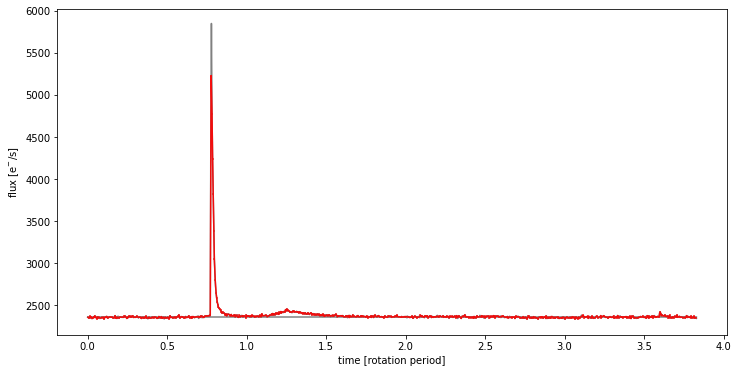

In [62]:

cf = pd.DataFrame({"phi":phi,"flux":flux, "t":t,
              "flux_err":flux_err, "median_":median})
cff = cf.groupby(pd.cut(cf.phi, 900)).apply(np.mean)
plt.figure(figsize=(12,6))
plt.plot(cf.phi/(2*np.pi), cf.flux,color="grey")
plt.errorbar(cff.phi/(2*np.pi), cff.flux, yerr=cff.flux_err, color="r", alpha=.9)
plt.plot(cf.phi/(2*np.pi), [median]*len(cf.phi),color="grey")
plt.xlabel("time [rotation period]")
plt.ylabel(r"flux [e$^{-}$/s]")
#plt.xlim(25,30)

In [63]:
# Write out light curve to use for MCMC fit
cff = cff.dropna(how="any")
cff.to_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv", index=False)

In [64]:
tstamp

'02_08_2020_17_58'

(2250.0, 6650.0)

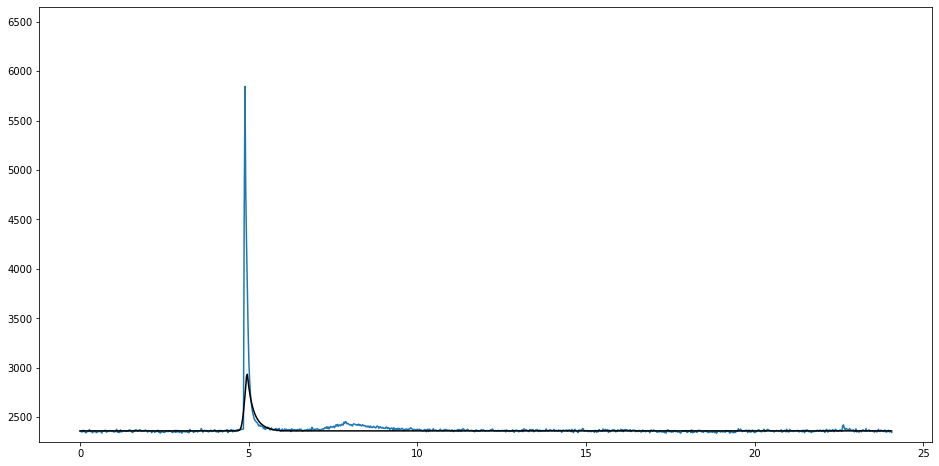

In [144]:
# Play with parameters to get a first guess for the MCMC 
# When fitting more than one flare, do one flare first, then the next etc.

# Flare peak time
phi_a =4.95

# Active region latitude
theta_a = -.2

# Flare amplitude
a = 1.7

# 2*FWHM of flare
fwhm =  .5


phi0 =-2
Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
phi_a_max = phi[-1]
#plt.plot(phi,flux)
radius = calculate_angular_radius(Fth, a, qlum, R,)
#theta_a, i_mu, phi_a, radius



plt.figure(figsize=(16,8))
plt.plot(phi,flux)
# for i in np.linspace(np.pi*.1,np.pi*.15,10):
#     plt.plot(phi, full_model(phi_a, i, a, fwhm, i_mu, phi0=phi0,
#                phi=phi, num_pts=50, qlum=qlum,
#                Fth=Fth, R=R, median=median), c="r", alpha=.31,)
plt.plot(phi, full_model(phi_a, theta_a, a, fwhm, i_mu, phi0=phi0,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median), c="k", alpha=1,);
# plt.xlim(1331,1333.25)
plt.ylim(2250,6650)

In [55]:
# Choose model:
log_prob = "log_probability"#_2flares2ars"
nparam = log_probs[log_prob]


# Save starting points and parameters for MCMC
with open(f"{CWD}/data/summary/inits.csv", "a") as f:
    firstout = ("date,ID,phi_a,theta_a,a,fwhm,Fth,phi0,"\
                "i_mu,i_sigma,radius_deg,R_Rsun,qlum_erg_s,"\
                "median,log_prob,nparam\n")
    out = (f"{tstamp},{target.ID},{phi_a},{theta_a},{a},{fwhm},{Fth.value},"\
           f"{phi0},{i_mu},{i_sigma},{radius},{(R/R_sun).value},{qlum.value},"\
           f"{median},{log_prob},{nparam}\n")
   # f.write(firstout)
    f.write(out)